# Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
import re
from wordcloud import WordCloud, STOPWORDS
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import os
import zipfile
import warnings

# Load the Dataset

In [ ]:
df = pd.read_excel("/content/df_bert.xlsx")

In [ ]:
df_2 = pd.read_excel("/content/df_gpt_all_sentiment_text.xlsx")

In [ ]:
df_3 = pd.read_excel(r"/content/df_Miaoli.xlsx")

In [ ]:
df_4 = pd.read_excel(r"/content/test_6class_pred.xlsx")
df_4 = df_4.dropna()
df_4[['information', 'justification', 'change', 'sanctions']] = df_4[['information', 'justification', 'change', 'sanctions']].astype('int')

In [ ]:
df_2 = df_2[['text', 'information', 'justification', 'change', 'sanctions', 'wordlen']]
df_3 = df_3[['text', 'information', 'justification', 'change', 'sanctions']]
df_4 = df_4[['text', 'information', 'justification', 'change', 'sanctions', 'wordlen']]

# Preprocessing

In [ ]:
df = pd.read_excel('/content/train_data.xlsx')

In [ ]:
df = pd.concat([df, df_2, df_3, df_4], ignore_index=True)

In [ ]:
df['wordlen'] = df['text'].str.len()

In [ ]:
df = df[df['wordlen'] <= 800]

In [ ]:
df

,Unnamed: 0,text,information,justification,change,sanctions,wordlen
0,0,但是有一件事情，本席感覺處理上還是非常的不妥，就是張顯耀違規施打疫苗事件。在這個事件裡面，雖...,0,1,0,0,286
1,1,好，謝謝市長。我相信假如今天疫苗夠的話，今天也不會產生這麼大的一個問題出來，也沒有類似這種案...,0,0,0,0,237
2,2,針對一個平民老百姓都可以如此的對待，所以希望市府團隊對於高雄市的團隊，以及公職人員及其親屬的...,0,1,1,0,290
3,3,市長、市長…。,0,0,0,0,7
4,4,我不是質疑這個部分。,0,0,0,0,10
...,...,...,...,...,...,...,...
12654,12850,市長，我知道了，所以分成兩邊，他做他的，你做你的嗎?,0,1,0,0,26
12655,12851,我們市民也希望看到市長是一個真正講實話、做實事的人。,0,0,0,0,26
12656,12852,幾戶?你認為高雄市照顧弱勢的社會住宅應該多少戶才夠?,0,1,0,0,26
12657,12853,是，但是你有關注你也會去了解一下，這個要不要讓他過。,0,0,0,0,26


## Data Visualization to Understand Class Distribution

In [ ]:
train = df.drop("wordlen", axis=1)
train = train[['text', 'information', 'justification', 'change', 'sanctions']]
train = train.drop_duplicates()

In [ ]:
train['text'] = train['text'].str[-512:]

In [ ]:
train['wordlen'] = train['text'].str.len()

In [ ]:
train = train[train['wordlen'] <= 512]

In [ ]:
train

,text,information,justification,change,sanctions,wordlen
0,但是有一件事情，本席感覺處理上還是非常的不妥，就是張顯耀違規施打疫苗事件。在這個事件裡面，雖...,0,1,0,0,286
1,好，謝謝市長。我相信假如今天疫苗夠的話，今天也不會產生這麼大的一個問題出來，也沒有類似這種案...,0,0,0,0,237
2,針對一個平民老百姓都可以如此的對待，所以希望市府團隊對於高雄市的團隊，以及公職人員及其親屬的...,0,1,1,0,290
3,市長、市長…。,0,0,0,0,7
4,我不是質疑這個部分。,0,0,0,0,10
...,...,...,...,...,...,...
13055,我知道，甚至還癱瘓了旗津交通，我覺得這個旗津交通，當然不是我的選區，但是還是特別要再特別講一...,0,0,0,0,86
13056,黃局長，請問一下，新冠疫情燃燒到現在已經二年多了，高雄市曾經確診的人數到底是多少?衛生局在人...,1,0,0,0,86
13057,謝謝市長，再問一下研考會，請問研考會，每次市政報告中各局處的業務報告，當它印成白紙黑字送到議...,0,1,0,0,86
13058,里長也有去告訴他們，市府這邊很不簡單通過了，現在簽的比例不夠，我也知道副市長對這個很重視，也...,0,0,1,0,87


In [ ]:
train['text'][235]

'國道10後，那裏的水路被切斷了，之後再改道也是無法順利排水。局長，這個問題你應該也非常深入去了解了，為了這件事，我相信市府水利局所有同仁也非常用心的投入，我也請教過你們局內的同仁，唯一能夠解決的就是…，你看這裡的排水口也是流到澄觀路橋下的曹公圳，因為地勢高低的關係，所以排水口的地勢已經非常低了，譬如遇到初一或十五海水漲潮的時候，水淹上來到曹公圳的橋下，出水口就已經滿了，所以水就會倒灌上來，所以鳳仁路和澄觀路的橋下，每年只要下大雨就會淹水、積水，要改善的是如何去攔截上面的排水。在高爾夫球場上方有一塊台糖土地，剛好在澄觀路的路旁，是不是可以在那裏蓋一座滯洪池，把雨水先收集起來就不會再淹水，你看!這裡是鳳仁路和澄觀路交叉路口，旁邊球場的水整個宣洩下來就會積淹水、倒灌，沒有流向中南橋，因為中南橋地勢比較高，它是流向地勢比較低的鳳仁路，整個水都淤積在這裡，這裡又是出水口，因為地勢高的關係，水滿了就會倒灌。所以最好的一個辦法，這裡是台糖地，我記得市長擔任行政院副院長的時候，行政院經濟部也有通過一個法令，只要地方政府需要開闢滯洪池來治水的，台糖土地可以提供無償使用，所以這一個地方是不是可以開闢蓋一座滯洪池，請市長簡單回答。'

In [ ]:
train = train.drop("wordlen", axis=1)

In [ ]:
target_labels= [col for col in train.columns if train[col].dtypes == 'int64']
target_labels

['information', 'justification', 'change', 'sanctions']

# Visualizing the Category of Dataset

In [ ]:
comments=train['text'].to_list()
comments[:5]

['但是有一件事情，本席感覺處理上還是非常的不妥，就是張顯耀違規施打疫苗事件。在這個事件裡面，雖然張顯耀先生他本身的做法是不對的，但是大家有沒有去思考為什麼張顯耀先生會去做這一件事情?為什麼他會去違規施打疫苗?最重要的就是我們的疫苗不足造成搶打的恐慌，因為每個人感受是不一樣，有些人感受到他的生命會造成很大的威脅，而保護市民生命財產的安全是我們政府的首要責任，所以針對這個事情，我想市府不能只是開罰而已，你要認真的去檢討，為什麼張顯耀先生會做這件事情?我相信今天也不是張顯耀先生會做件事情而已，絕對非常的多。所以針對這件事情，我還是請市長回應一下，你的感覺是如何?請市長回答。',
 '好，謝謝市長。我相信假如今天疫苗夠的話，今天也不會產生這麼大的一個問題出來，也沒有類似這種案件出來，所以整個國家的整體疫苗政策確實造成民眾非常大的恐慌，在這一波疫情每個人的感受是不一樣，而且台灣的感染死亡率相對全世界是最高的。有的人雖然恐慌，但是他可以等疫苗，而有些人恐慌的感覺不一樣，也許可能明天就會感染死亡，在他內心深處相對地非常的恐慌，所以本席絕對相信會去違規施打的人絕對非常的多，如果按照我們市府團隊的標準，包括張顯耀先生目前也不是擔任公職，他現在是一個平民老百姓。',
 '針對一個平民老百姓都可以如此的對待，所以希望市府團隊對於高雄市的團隊，以及公職人員及其親屬的施打日期應該公布出來，讓全民共同來檢視。為什麼要全民共同來檢視?尤其5、6月份，大家都知道，我們可以針對5、6月份來共同檢視這些名單，尤其這一波的疫情，防疫人員相對地非常的重要，5、6月剛好是一個高峰，所以第一類跟第二類的所有醫護人員，還有疫調人員絕對是最先要去施打。所以本席建議市長是不是針對所有的公職人員也好，市府團隊也好，絕對要公布，包括調查他是不是在5、6月來施打的?把這些名單公布出來。我想做任何事情只有自清才能取得人民共同的信任。針對這個部分，請問市長有沒有辦法?請市長回答。',
 '市長、市長…。',
 '我不是質疑這個部分。']

In [ ]:
train[target_labels].sum()

information      3373
justification    4907
change           3996
sanctions         874
dtype: int64

In [ ]:
# Calculate the value counts for each target label
value_counts = train[target_labels].sum()

# Add the count for the "neither" category (where all target labels are 0)
value_counts['No label'] = len(train) - value_counts.sum()

fig =px.bar(x= value_counts.index,
            y= value_counts.values,
            color=value_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24_r,
            title='<b>Counts of Target Labels')

fig.update_layout(title='Counts of Target Labels',
                  xaxis_title='Toxicity Labels',
                  yaxis_title='Counts',
                  template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Counts of Target Labels.html', auto_open = True)

'Counts of Target Labels.html'

In [ ]:
data = train[target_labels]

<Axes: title={'center': 'Correlation of features & targets'}>

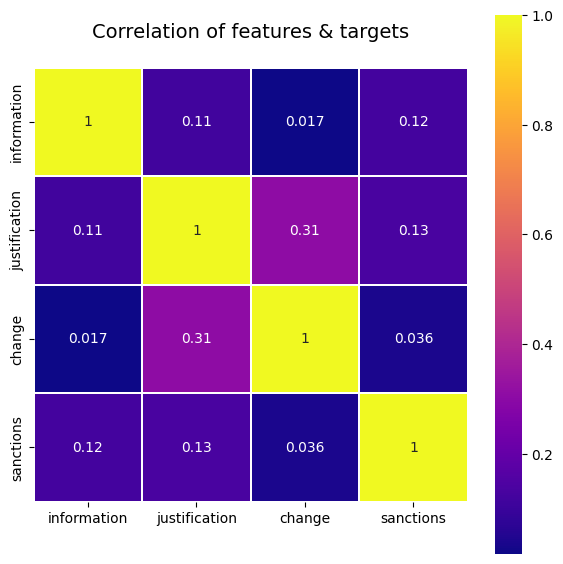

In [ ]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

# Split the dataset into Train, Test and Validation

In [ ]:
# Split data into training, testing sets & validation sets
Train_texts, Test_texts, Train_labels, Test_labels = train_test_split(
    comments, train[target_labels].values, test_size=0.2, random_state=2023)

#validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(
    Test_texts, Test_labels, test_size=0.5, random_state=23)

print('numbers of training Dataset ',len(Train_texts))
print('numbers of testing Dataset',len(test_texts))
print('numbers of validation Dataset',len(val_texts))

numbers of training Dataset  8040
numbers of testing Dataset 1005
numbers of validation Dataset 1005


# Fine-tune BERT Model for Multilabel Classification

In [ ]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=512):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []

    # Iterate through each comment in the 'comments' list
    for comment in comments:
        # Tokenize and encode the comment using the BERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists of tokenized inputs and attention masks to PyTorch tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a PyTorch tensor with the data type float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels

In [ ]:
# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', do_lower_case=True)

# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model = model.to(device)

cuda


In [ ]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer,
    Train_texts,
    Train_labels
)

# Step 4: Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
    tokenizer,
    test_texts,
    test_labels
)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    val_texts,
    val_labels
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



## Creating DataLoaders for training dataset

In [ ]:
# Creating DataLoader for the balanced dataset
batch_size = 16
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#val
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print('Batch Size :',train_loader.batch_size)
Batch =next(iter(train_loader))
print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n',Batch[1][0])
print('Corresponding Label:',Batch[2][0])

Batch Size : 16
Each Input ids shape : torch.Size([16, 512])
Input ids :
 tensor([ 101, 2769,  947, 4412, 1762, 6313, 3136, 2339, 1243, 2229, 7269,  511,
         785, 2552, 6662, 8024, 6250, 2533, 3315, 2375, 1762, 6857, 3613, 2137,
        3309, 1920, 3298, 7502, 2356, 7269, 3177, 3124, 1841, 1440, 4638, 3229,
         952, 8024, 3300, 6341, 1168, 6857,  671, 3454, 6662,  872,  947, 2356,
        2424, 1343, 6794,  749, 7077, 3428, 8024, 2769, 6341, 6882, 6857,  943,
        4696, 4638, 3221,  753, 1282, 2407, 2399,  889, 8024, 1765, 3175,  677,
        2792, 3300, 4638, 3696, 2692,  807, 6134, 1469, 3696, 4707, 3297, 3309,
        2521, 6857, 3454, 6662, 5543, 1917, 2868, 2184, 8024, 6629, 1044, 1920,
        2157, 2533, 1168, 6244, 2622, 3229, 2523, 7770, 5646, 8024, 5178, 3362,
         872,  947, 1343, 6794, 7077, 3428, 8024,  124,  943, 3333, 5862, 4493,
        5635, 3300,  782, 5481, 1168, 3315, 2375, 4638, 6549, 6273, 8024, 2769,
        1762, 1912, 7481, 6878, 1168,  800,  9

### Initialising optimizer
Initializes the optimizer for training the model

Adam with Weight Decay (AdamW) is a variant of the Adam optimizer that incorporates weight decay (L2 regularization) during the parameter updates. It is an extension of the original Adam optimizer and addresses some of its limitations when using weight decay as a regularization technique.

In [ ]:
# Optimizer setup
optimizer = AdamW(model.parameters(), lr=0.00003)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



# Model training

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

train_loss_history = []
train_acc_history=[]
val_loss_history = []
val_accuracy_history = []

def train_model(model, train_loader, val_loader, optimizer, device, num_epochs):
    model=model.to(device)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions=0
        total_predictions=0
        label_accuracies = [0] * 4
        label_f1_scores = [0] * 4
        for step, batch in enumerate(train_loader):
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            # 记录训练损失
            train_loss_history.append(loss.item())
            logits = outputs.logits
            predictions = torch.round(torch.sigmoid(logits))
            correct_predictions += torch.sum(predictions == labels).item()
            total_predictions += labels.size(0)*labels.size(1)

            label_predictions = torch.round(torch.sigmoid(logits))
            label_f1 = [f1_score(labels[:, i].detach().cpu().numpy(), label_predictions[:, i].detach().cpu().numpy(), average='binary', zero_division=1) for i in range(4)]

            for i in range(4):  # Assuming 4 labels
                label_correct = torch.sum(label_predictions[:, i] == labels[:, i]).item()
                label_total = labels.size(0)
                label_accuracy = label_correct / label_total
                label_accuracies[i] += label_accuracy
                label_f1_scores[i] += label_f1[i]

            if (step + 1) % 150 == 0:
                print(f'Epoch {epoch+1}, Step {step+1}, Training Loss: {loss.item()}')
            if(step+1)==780:
                break
        train_accuracy=correct_predictions/total_predictions
        train_acc_history.append(train_accuracy)

        label_accuracies = [acc / len(train_loader) for acc in label_accuracies]
        label_f1_scores = [score / len(train_loader) for score in label_f1_scores]
        # Print train accuracy for each label
        for i in range(4):
            print(f'Train Accuracy for Label {i + 1}: {label_accuracies[i]}')
            print(f'Train F1 Score for Label {i + 1}: {label_f1_scores[i]}')

        model.eval()
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [t.to(device) for t in batch]

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                logits = outputs.logits

                predictions = torch.round(torch.sigmoid(logits))
                correct_predictions += torch.sum(predictions == labels).item()
                total_predictions += labels.size(0)*labels.size(1)

        val_accuracy = correct_predictions / total_predictions

        val_loss_history.append(val_loss / len(val_loader))
        val_accuracy_history.append(val_accuracy)

        print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)},Train Accuracy: {train_accuracy}, Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_accuracy}')

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.subplot(1,3,3)
    plt.plot(train_acc_history,label='train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10)

Epoch 1, Step 150, Training Loss: 0.3831297755241394
Epoch 1, Step 300, Training Loss: 0.43464040756225586
Epoch 1, Step 450, Training Loss: 0.38016384840011597
Epoch 1, Step 600, Training Loss: 0.5345110893249512
Train Accuracy for Label 1: 0.7744865718799369
Train F1 Score for Label 1: 0.6085597393453651
Train Accuracy for Label 2: 0.7865126382306478
Train F1 Score for Label 2: 0.8076821421513537
Train Accuracy for Label 3: 0.7840639810426541
Train F1 Score for Label 3: 0.7548495886823683
Train Accuracy for Label 4: 0.9044167983149025
Train F1 Score for Label 4: 0.3088730911005793
Epoch 1, Training Loss: 0.41005606111286186,Train Accuracy: 0.8123580527303249, Validation Loss: 0.3358613034710288, Validation Accuracy: 0.8605845181674565
Epoch 2, Step 150, Training Loss: 0.2511955499649048
Epoch 2, Step 300, Training Loss: 0.2963261306285858
Epoch 2, Step 450, Training Loss: 0.2774654030799866
Epoch 2, Step 600, Training Loss: 0.2705386281013489
Train Accuracy for Label 1: 0.86275013164

In [ ]:
len(train_loader)

# Model Evaluation

In [ ]:
# Evaluate the Model
def evaluate_model(model, test_loader, device):
    model.eval()

    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Get model's predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted_probs_batch = torch.sigmoid(outputs.logits)  # Use sigmoid for multilabel classification
            predicted_probs.append(predicted_probs_batch.cpu().numpy())

            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # Combine predictions and labels for evaluation
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
    predicted_labels = (predicted_probs > 0.5).astype(int)  # Apply threshold for binary classification

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')

    # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, device):
    model.eval()

    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Get model's predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted_probs_batch = torch.sigmoid(outputs.logits)  # Use sigmoid for multilabel classification
            predicted_probs.append(predicted_probs_batch.cpu().numpy())

            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # Combine predictions and labels for evaluation
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
    predicted_labels = (predicted_probs > 0.5).astype(int)  # Apply threshold for binary classification

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')

    # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

    # Calculate and print F1 score for each label
    f1_scores = f1_score(true_labels, predicted_labels, average=None)
    for i, f1 in enumerate(f1_scores):
        print(f'F1 Score (Label {i}): {f1:.4f}')

    # Calculate and print accuracy for each label
    for i in range(true_labels.shape[1]):  # Loop over each label
        label_accuracy = accuracy_score(true_labels[:, i], predicted_labels[:, i])
        print(f'Accuracy (Label {i}): {label_accuracy:.4f}')

# Example usage:
# evaluate_model(model, test_loader, device)

In [ ]:
# Call the function to evaluate the model on the test data
evaluate_model(model, test_loader, device)

## Save the model

In [ ]:
# Save the tokenizer and model in the same directory
output_dir = "/content/Saved_model"
model.save_pretrained(output_dir)  # Save model's state dictionary and configuration
tokenizer.save_pretrained(output_dir)  # Save tokenizer's configuration and vocabulary

## Load the model

In [ ]:
# Load the tokenizer and model from the saved directory
model_name ="/content/Saved_model"
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(model_name).to(device)

# Prediction for user input

In [ ]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer,device=device):
    user_input = [input_text]

    user_encodings = tokenizer(user_input, truncation=True, padding=True, return_tensors="pt")

    user_dataset = TensorDataset(user_encodings['input_ids'], user_encodings['attention_mask'])

    user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for batch in user_loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.sigmoid(logits)
    predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
    return predicted_labels[0].tolist()

In [ ]:
text = '市長，請問今年預算多少?'
predict_user_input(input_text=text)

In [ ]:
text = '請處長不要回答。市長，你覺得合理嗎？'
predict_user_input(input_text=text)

In [ ]:
text = '市長，光是103年到106年的一次性設備採購，就花費二億九千多萬元。校長，妳攤提了四億多元，右手又花了二億九千多萬元，請問一次性設備是買了什麼東西？細項是什麼？請說明。'
predict_user_input(input_text=text)

In [ ]:
text = '市長！請你加速。不要再讓你的政策龜速地進行，不要再讓你的政策全部跳票。'
predict_user_input(input_text=text)

In [ ]:
text = '市長，我建議你去把馬路鋪好。'
predict_user_input(input_text=text)

In [ ]:
text = '真的是笑死，你這市長當得有夠爛'
predict_user_input(input_text=text)

In [ ]:
text = '你的市府裡面因為財團當道、官僚得志，所以都是內鬼。這些內鬼不只是扯你的後腿，而且用讒言來矇蔽你，讓你當成1個瞎眼的市長。不只內鬼一大堆，還有一堆吸血鬼。世大運花錢如流水，整個勞務採購完全浮濫，廠商要5毛、你給1塊，糟蹋公帑、浪費極致！'
predict_user_input(input_text=text)

In [ ]:
text = '可不可以幫小港的市民蓋一個圖書館?'
predict_user_input(input_text=text)

# Submission